In [ ]:
from __future__ import print_function

#Numpy, pandas ans os
import numpy as np
import pandas as pd
import os
# matplotlib for displaying the output
import matplotlib.pyplot as plt

# Librosa for audio
import librosa


#parselmouth for audio
import parselmouth
from parselmouth.praat import call
from sklearn.decomposition import PCA
import statistics

#essentia

import essentia.standard
import essentia.streaming
from essentia.standard import *


#librairies for classification
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, cross_val_predict, KFold, cross_val_score
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, make_scorer, confusion_matrix

from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import ADASYN
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest

from sklearn.model_selection import GridSearchCV
import joblib
#for warning
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category= ConvergenceWarning)

warnings.filterwarnings("ignore", category= UserWarning)
warnings.filterwarnings("ignore", category= RuntimeWarning)

Dataframe to match audio with emotion

In [6]:
cd drive/My\ Drive

/content/drive/My Drive


In [8]:
parent_dir = "ravdess" #audio data folder
def prepare_datadf(parent_dir): # a function whose parameter is the audio folder
    df = pd.DataFrame(columns = ['audio', 'label']) #dataframe columns
    
    for  fichier_audio in os.listdir(parent_dir): # for each element in the audio folder
        folder_path = os.path.join(parent_dir, fichier_audio) # path of each item  in the audio folder
        
       
        
        if(os.path.isdir(folder_path)): 
            audios = os.listdir(folder_path) #content of each emotional file
            for i in audios:
                emotion = None
                if i.endswith('outNoise.wav'):
                    if i[7] == '7':      ##this specifies that we class disgust emotion against the others
                                    #7 represents the 7th column of the file name
                                    # This number varies for each emotion(ex calm = '2', fearfull = '6')
                        emotion = 1
                    
                    else:
                        emotion = 0
                    df = df.append(pd.DataFrame({'audio':[os.path.join(fichier_audio, i)], 'label':[emotion]}), 
                           ignore_index=True)  #adding values to the defined df:
                                            #the audio column will take the audios_path, 
                                            #and the emotion column will take the corresponding emotion, ie the name of the folder
    #Shuffling for randomness
    df = df.sample(frac=1.0).reset_index(drop=True)
    return df
datadf = prepare_datadf(parent_dir) #function call
display(datadf.head()) #dataframe display

	

,audio,label
0,angry/03-01-05-01-01-02-17_norm_outNoise.wav,0
1,sad/03-01-04-02-01-01-23_norm_outNoise.wav,0
2,neutral/03-01-01-01-01-01-17_norm_outNoise.wav,0
3,sad/03-01-04-02-01-01-11_norm_outNoise.wav,0
4,sad/03-01-04-01-01-02-11_norm_outNoise.wav,0


Number of labels 1 and 0

In [23]:
array=datadf.values
audios=array[:,0]
emotions=array[:,1]
print(datadf.label.value_counts())

0    1053
1     192
Name: label, dtype: int64


Preprocessing

Function for framing and windowing the audio_files

In [27]:
def fram_window(audio_path):
    loader = essentia.standard.MonoLoader(filename= audio_path)

    # and then we actually perform the loading:
    audio = loader()

    w = Windowing(type = 'hann')
    spectrum = Spectrum() 
    #default parameter (hopsize and framesize)
    hopSize = 512
    frameSize = 1024 
    for frame in FrameGenerator(audio, frameSize=1024, hopSize=512, startFromZero=True):
        spect = spectrum(w(frame))
    return spect

function for features extraction:

In [28]:
def extract_features(audio_path):
    features = []
    
    
    #Load audios with the different libraries
      
    y,sr = librosa.load(audio_path)
    sound = parselmouth.Sound(audio_path)
    fs, sig = scipy.io.wavfile.read(audio_path) 
    
    pitch = call(sound, "To Pitch", 0.0, 75, 600)
    mean_pitch = call(pitch, "Get mean", 0, 0, "Hertz")
    
    spec =  fram_window(audio_path) 
    duration = librosa.get_duration(y= spec, sr=sr)
    energy = np.sum(spec ** 2) / np.float64(len(spec))
            
    lpc = librosa.core.lpc(spec,16)
            
    zcr = librosa.feature.zero_crossing_rate(spec)
               
    #gfccs = gfcc(sig= spec, fs=fs, num_ceps=13)    
    mfcc = librosa.feature.mfcc(y= spec, sr=sr, n_mfcc = 13)
        
    harmonicity = call(sound, "To Harmonicity (cc)", 0.01, 75, 0.1, 1.0)
    HNR = call(harmonicity, "Get mean", 0, 0)
                
    pointProcess = call(sound, "To PointProcess (periodic, cc)", 75, 500)
    localJitter = call(pointProcess, "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3)
    localabsoluteJitter = call(pointProcess, "Get jitter (local, absolute)", 0, 0, 0.0001, 0.02, 1.3)

    localShimmer =  call([sound, pointProcess], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    localdbShimmer = call([sound, pointProcess], "Get shimmer (local_dB)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
        
    formants = call(sound, "To Formant (burg)", 0.0, 5, 5500, 0.025, 100)
    numPoints = call(pointProcess, "Get number of points")

    f1_list = []
    f2_list = []
    f3_list = []
    f4_list = []
    
    # Measure formants only at glottal pulses
    for point in range(0, numPoints):
        point += 1
        t = call(pointProcess, "Get time from index", point)
        f1 = call(formants, "Get value at time", 1, t, 'Hertz', 'Linear')
        f2 = call(formants, "Get value at time", 2, t, 'Hertz', 'Linear')
        f3 = call(formants, "Get value at time", 3, t, 'Hertz', 'Linear')
        f4 = call(formants, "Get value at time", 4, t, 'Hertz', 'Linear')
        f1_list.append(f1)
        f2_list.append(f2)
        f3_list.append(f3)
        f4_list.append(f4)
        
    f1_list = [f1 for f1 in f1_list if str(f1) != 'nan']
    f2_list = [f2 for f2 in f2_list if str(f2) != 'nan']
    f3_list = [f3 for f3 in f3_list if str(f3) != 'nan']
    
    f4_list = [f4 for f4 in f4_list if str(f4) != 'nan']

    f1_mean = statistics.mean(f1_list)
    f2_mean = statistics.mean(f2_list)
    f3_mean = statistics.mean(f3_list)
    f4_mean = statistics.mean(f4_list)
    
    rapJitter = call(pointProcess, "Get jitter (rap)", 0, 0, 0.0001, 0.02, 1.3)
    ppq5Jitter = call(pointProcess, "Get jitter (ppq5)", 0, 0, 0.0001, 0.02, 1.3)
    ddpJitter = call(pointProcess, "Get jitter (ddp)", 0, 0, 0.0001, 0.02, 1.3)   
            
    apq3Shimmer = call([sound, pointProcess], "Get shimmer (apq3)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    aqpq5Shimmer = call([sound, pointProcess], "Get shimmer (apq5)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    apq11Shimmer =  call([sound, pointProcess], "Get shimmer (apq11)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    ddaShimmer = call([sound, pointProcess], "Get shimmer (dda)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    
    features.append(mean_pitch)
    features.append(duration)
    features.append(energy)
    features.append(np.mean(zcr))
    features.append(np.mean(lpc))
    
        
    features.append(np.mean(mfcc))
    
    #features.append(np.mean(gfccs))
    features.append(HNR)
    
    features.append(localJitter)
    features.append(np.mean(localabsoluteJitter))
    
    features.append(localShimmer)
    features.append(localdbShimmer)
    features.append(f1_mean)   
    features.append(f2_mean)
    features.append(f3_mean)
    features.append(f4_mean)
        
    features.append(rapJitter)
    features.append(ppq5Jitter)
    features.append(ddpJitter)
    
    features.append(apq3Shimmer)
    features.append(aqpq5Shimmer)
    features.append(apq11Shimmer)
    features.append(ddaShimmer)
        
    return features

Application of features extraction function on all audios

In [29]:
all_features = []
for audio_file in array[:,0]:
    if audio_file.endswith('.wav'):
        
        features = extract_features(parent_dir+'/'+audio_file)
        all_features.append(features)

In [30]:
print(len(all_features))

1245


Encode labels

In [33]:
encod = preprocessing.LabelEncoder()
emotions = array[:,1]
encod.fit(emotions)
list(encod.classes_)
labels=encod.transform(emotions)

Scale features

In [32]:
scaler = StandardScaler()
scaler.fit(all_features)
X_scaler = scaler.transform(all_features)

Oversampling

In [42]:
ada = ADASYN(sampling_strategy = 0.6)
X, y = ada.fit_sample(X_scaler, labels.ravel())
print("After OverSampling, counts of label '1': {}".format(sum(y==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y==0)))

After OverSampling, counts of label '1': 596
After OverSampling, counts of label '0': 1053


Process to select features after oversampling with ADASYN : the code first takes in a list the position of the features that are deleted, during the 1000 iterations, then uses a dataframe to count them. we notice that the features " [1, 2, 3, 5, 8, 14, 20]   " are deleted 886 times.

In [ ]:
compt=0
df = pd.DataFrame(columns = ['iteration', 'X_removed'])
while compt < 1000:
    ada = ADASYN(sampling_strategy = 0.6)
    
    X, y = ada.fit_sample(X_scaler, labels.ravel())
    X = np.asarray(X)
    Kbest = SelectKBest(k="all")
    selec_features = Kbest.fit(X, y)
    alpha = 0.01
    #remove non_signifiant features selection
    X_selec = X[:,np.where(selec_features.pvalues_ < alpha)[0]]
    
    pos_removed = []    
    for i in range(len(X[0])):
   
        if X[0][i] not in X_selec[0]:
            #print(i)
            pos_removed.append(i)
            str_pos_removed = str(pos_removed)
    #print(pos_removed)
    
    compt = compt + 1
    df= df.append(pd.DataFrame({'iteration':[compt], 'X_removed':[str_pos_removed]}), ignore_index=True)
display(df.head())

print("Number of occurrences of features that are removed :")
df["X_removed"].value_counts()

,iteration,X_removed
0,1,"[1, 2, 3, 5, 8, 14, 20]"
1,2,"[1, 2, 3, 5, 8, 14, 20]"
2,3,"[1, 2, 3, 5, 8, 14, 20]"
3,4,"[1, 2, 3, 5, 8, 14, 20]"
4,5,"[1, 2, 3, 5, 8, 14, 20]"


Number of occurrences of features that are removed :


[1, 2, 3, 5, 8, 14, 20]    886
[1, 2, 3, 8, 14, 20]       114
Name: X_removed, dtype: int64

In [ ]:
#manually feature selection
X_selected = []
for i in range(len(X)):
    #print(w[i][0])
    X_selected.append([X[i][0],  X[i][4], X[i][6], X[i][7], X[i][9], X[i][10],
               X[i][11], X[i][12], X[i][13],  X[i][15], 
                X[i][16], X[i][17], X[i][18], X[i][19], X[i][21]])

Split dataset to Train, Test and Val

In [ ]:
#split train test
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=1)

print(len(X_train))
print(len(X_test))
print(len(X_val))

1055
330
264


Research of best parameters for all classifiers

In [ ]:
classifiers = {
    'KNeighborsClassifier': KNeighborsClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'SVC': SVC(),
    'RandomForest' : RandomForestClassifier(),
    
    'LogisticRegression' : LogisticRegression(),
    'StochasticGradient' : SGDClassifier(),
    
    'XGboost': XGBClassifier()
}

params = {'StochasticGradient' : [{'loss': ['log', 'hinge', 'modified_huber', 'squared_hinge', 'perceptron'],
                'penalty': ['l1', 'l2', 'elasticnet'],
                'alpha': [10 ** x for x in range(-6, 1)],
                'l1_ratio': [0, 0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95, 1]}],  
    
    
    
    'KNeighborsClassifier' : [{'n_neighbors': list(range(1,15))},
    {'metric': ['minkowski','euclidean','manhattan']}],
          
              
          
          
           'LogisticRegression': [{'C': [0.001,0.01,0.1,1,10,100],
                           'penalty' : [ 'l2']}] ,
    
          
           'DecisionTreeClassifier': [{'max_depth': [1,2,3,4,5,6,7,8,9,10]},
    {'criterion': ['gini', 'entropy']},
    {'min_samples_leaf': [1,2,3,4,5,6,7,8,9,10]}],
          
       'SVC':[{'C': [0.001, 0.01, 0.1, 1, 10], 
    'gamma' : [0.001, 0.01, 0.1, 1], 
    'kernel': ['linear','rbf']}] ,
    
    'RandomForest':[{'max_depth': [1,2,3,4,5,6,7,8,9,10],
    'criterion': ['gini', 'entropy'],
    'min_samples_leaf': [1,2,3,4,5,6,7,8,9,10]}] ,
    
   
   
          
    'XGboost' :[{'max_depth': range(3,10,2),
                 'min_child_weight': range(1,6,2),
                 'gamma': [0.1,0.2,0.3,0.4],
                 'subsample': [0.5, 0.6, 0.7, 0.8, 0.9]
                }]
         }





class Result:
     def __init__(self,name, score, parameters):
         self.name = name
         self.score = score
         self.parameters = parameters
     def __repr__(self):
         return repr((self.name, self.score, self.parameters))

X_train_array = np.asarray(X_train)       
results = []
for key,value in classifiers.items():
    gd_sr = GridSearchCV(estimator=value,  
                     param_grid=params[key],
                     scoring='accuracy',
                     cv=5,
                     n_jobs=1,
                     iid=True)
    gd_sr.fit(X_train_array, y_train)  
    result=Result(key,gd_sr.best_score_,gd_sr.best_estimator_)
    results.append(result)   
    
    
    
results=sorted(results, key=lambda result: result.score, reverse=True) 

print (' the best result: \n')
print ('Classifier : ',results[0].name, 
       ' score %0.2f' %results[0].score, 
       ' with ',results[0].parameters,'\n')

print ('all results: \n')
for result in results:
    print ('Classifier : ',result.name, 
           ' score %0.2f' %result.score, 
           ' with ',result.parameters,'\n')

 the best result: 

Classifier :  SVC  score 0.90  with  SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False) 

all results: 

Classifier :  SVC  score 0.90  with  SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False) 

Classifier :  XGboost  score 0.87  with  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.2,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
             

LR : 


 accuracy_test: 0.6636363636363637 


 confusion_matrix_svm_test 
 [[168  34]
 [ 77  51]]

 precision_test : 0.6

 recall_test : 0.3984375

 f1_score : 0.4788732394366197

               precision    recall  f1-score   support

           0       0.69      0.83      0.75       202
           1       0.60      0.40      0.48       128

    accuracy                           0.66       330
   macro avg       0.64      0.62      0.62       330
weighted avg       0.65      0.66      0.65       330



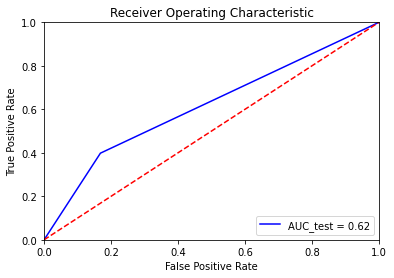

KNN : 


 accuracy_test: 0.8696969696969697 


 confusion_matrix_svm_test 
 [[163  39]
 [  4 124]]

 precision_test : 0.7607361963190185

 recall_test : 0.96875

 f1_score : 0.852233676975945

               precision    recall  f1-score   support

           0       0.98      0.81      0.88       202
           1       0.76      0.97      0.85       128

    accuracy                           0.87       330
   macro avg       0.87      0.89      0.87       330
weighted avg       0.89      0.87      0.87       330



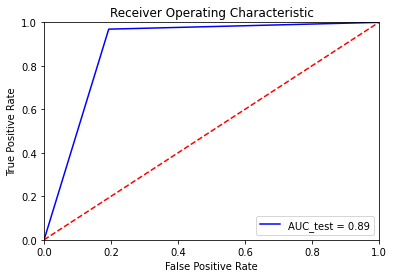

CART : 


 accuracy_test: 0.7515151515151515 


 confusion_matrix_svm_test 
 [[169  33]
 [ 49  79]]

 precision_test : 0.7053571428571429

 recall_test : 0.6171875

 f1_score : 0.6583333333333334

               precision    recall  f1-score   support

           0       0.78      0.84      0.80       202
           1       0.71      0.62      0.66       128

    accuracy                           0.75       330
   macro avg       0.74      0.73      0.73       330
weighted avg       0.75      0.75      0.75       330



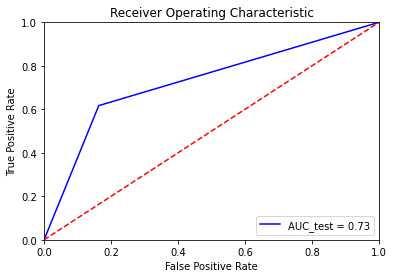

NB : 


 accuracy_test: 0.603030303030303 


 confusion_matrix_svm_test 
 [[100 102]
 [ 29  99]]

 precision_test : 0.4925373134328358

 recall_test : 0.7734375

 f1_score : 0.601823708206687

               precision    recall  f1-score   support

           0       0.78      0.50      0.60       202
           1       0.49      0.77      0.60       128

    accuracy                           0.60       330
   macro avg       0.63      0.63      0.60       330
weighted avg       0.67      0.60      0.60       330



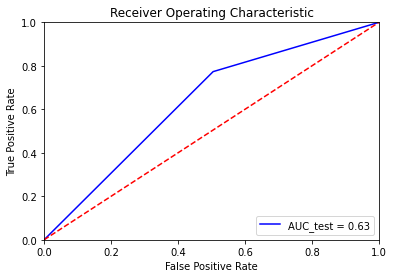

SVM : 


 accuracy_test: 0.9484848484848485 


 confusion_matrix_svm_test 
 [[198   4]
 [ 13 115]]

 precision_test : 0.9663865546218487

 recall_test : 0.8984375

 f1_score : 0.9311740890688258

               precision    recall  f1-score   support

           0       0.94      0.98      0.96       202
           1       0.97      0.90      0.93       128

    accuracy                           0.95       330
   macro avg       0.95      0.94      0.95       330
weighted avg       0.95      0.95      0.95       330



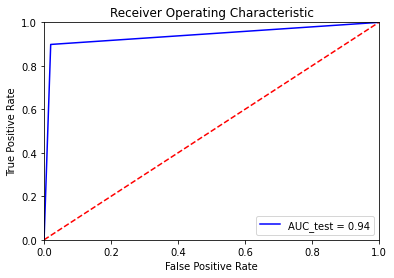

SGD : 


 accuracy_test: 0.6727272727272727 


 confusion_matrix_svm_test 
 [[153  49]
 [ 59  69]]

 precision_test : 0.5847457627118644

 recall_test : 0.5390625

 f1_score : 0.5609756097560975

               precision    recall  f1-score   support

           0       0.72      0.76      0.74       202
           1       0.58      0.54      0.56       128

    accuracy                           0.67       330
   macro avg       0.65      0.65      0.65       330
weighted avg       0.67      0.67      0.67       330



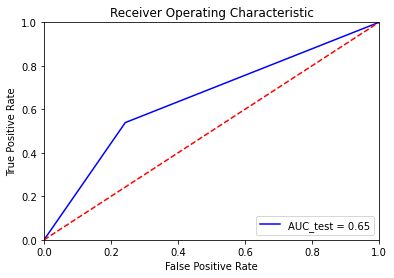

RF : 


 accuracy_test: 0.8454545454545455 


 confusion_matrix_svm_test 
 [[177  25]
 [ 26 102]]

 precision_test : 0.8031496062992126

 recall_test : 0.796875

 f1_score : 0.8

               precision    recall  f1-score   support

           0       0.87      0.88      0.87       202
           1       0.80      0.80      0.80       128

    accuracy                           0.85       330
   macro avg       0.84      0.84      0.84       330
weighted avg       0.85      0.85      0.85       330



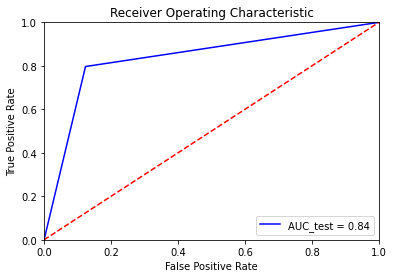

Xgboost : 


 accuracy_test: 0.8606060606060606 


 confusion_matrix_svm_test 
 [[177  25]
 [ 21 107]]

 precision_test : 0.8106060606060606

 recall_test : 0.8359375

 f1_score : 0.8230769230769232

               precision    recall  f1-score   support

           0       0.89      0.88      0.89       202
           1       0.81      0.84      0.82       128

    accuracy                           0.86       330
   macro avg       0.85      0.86      0.85       330
weighted avg       0.86      0.86      0.86       330



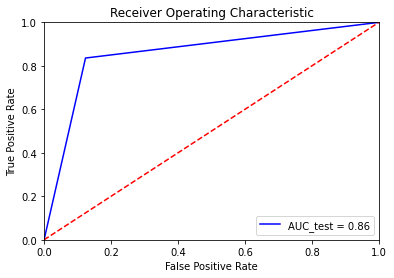

In [ ]:
models = []

models.append(('LR', LogisticRegression(C = 0.1, penalty ='l2'))) #  name and function of classification
models.append(('KNN', KNeighborsClassifier(metric = 'minkowski', n_neighbors = 1)))
models.append(('CART', DecisionTreeClassifier(criterion = 'entropy', min_samples_leaf = 1)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(C = 10, gamma = 1, kernel = 'rbf')))
models.append(('SGD',SGDClassifier(alpha = 0.001, l1_ratio = 0.1, loss = 'log', penalty = 'elasticnet')))
models.append(('RF', RandomForestClassifier(criterion = 'gini', max_depth = 10, min_samples_leaf = 1)))
models.append(('Xgboost', XGBClassifier(gamma = 0.2, max_depth = 7, min_child_weight = 1, subsample = 0.7)))


for name,model in models:
    X_train_array = np.asarray(X_train)
    X_test_array = np.asarray(X_test)
    model.fit(X_train_array, y_train)
    result_test = model.predict(X_test_array)
    
    print(name, ':', '\n')
    
    print('\n accuracy_test:',accuracy_score(y_test, result_test),'\n')
    conf_test = confusion_matrix(y_test, result_test)
    
    print ('\n confusion_matrix_svm_test \n',conf_test)

    print ('\n precision_test :', precision_score(y_test, result_test))
    print('\n recall_test :', recall_score(y_test, result_test))
    print('\n f1_score :', f1_score(y_test, result_test))

    print('\n' ,classification_report(y_test, result_test))

     #auc_test

    fpr, tpr, threshold = metrics.roc_curve(y_test, result_test) 
    roc_auc_test = metrics.auc(fpr, tpr)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC_test = %0.2f' % roc_auc_test)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()




    filename = name+'_'+'disgust_ravdess_MODEL.pkl'
    joblib.dump(model, filename)

Validation

validation avec LR_disgust_ravdess_MODEL.pkl :

 accuracy_val: 0.7348484848484849 


 confusion_matrix_val 
 [[151  22]
 [ 48  43]]

 precision_val : 0.6615384615384615

 recall_val : 0.4725274725274725

 f1_score : 0.5512820512820512

               precision    recall  f1-score   support

           0       0.76      0.87      0.81       173
           1       0.66      0.47      0.55        91

    accuracy                           0.73       264
   macro avg       0.71      0.67      0.68       264
weighted avg       0.73      0.73      0.72       264



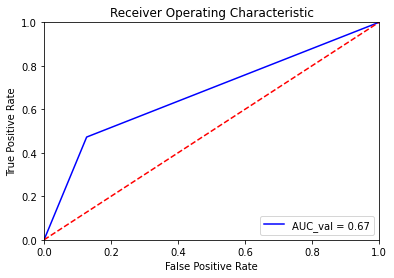

validation avec KNN_disgust_ravdess_MODEL.pkl :

 accuracy_val: 0.8522727272727273 


 confusion_matrix_val 
 [[137  36]
 [  3  88]]

 precision_val : 0.7096774193548387

 recall_val : 0.967032967032967

 f1_score : 0.8186046511627908

               precision    recall  f1-score   support

           0       0.98      0.79      0.88       173
           1       0.71      0.97      0.82        91

    accuracy                           0.85       264
   macro avg       0.84      0.88      0.85       264
weighted avg       0.89      0.85      0.86       264



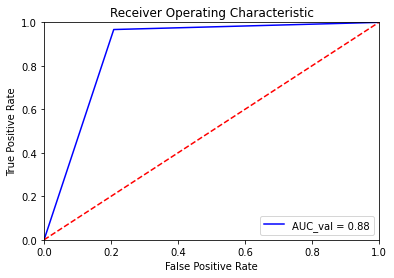

validation avec CART_disgust_ravdess_MODEL.pkl :

 accuracy_val: 0.7348484848484849 


 confusion_matrix_val 
 [[131  42]
 [ 28  63]]

 precision_val : 0.6

 recall_val : 0.6923076923076923

 f1_score : 0.6428571428571429

               precision    recall  f1-score   support

           0       0.82      0.76      0.79       173
           1       0.60      0.69      0.64        91

    accuracy                           0.73       264
   macro avg       0.71      0.72      0.72       264
weighted avg       0.75      0.73      0.74       264



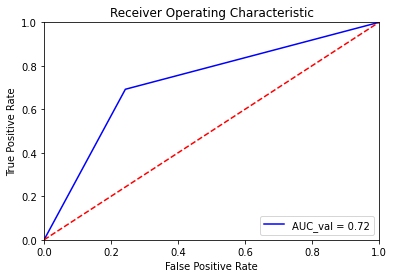

validation avec NB_disgust_ravdess_MODEL.pkl :

 accuracy_val: 0.6022727272727273 


 confusion_matrix_val 
 [[96 77]
 [28 63]]

 precision_val : 0.45

 recall_val : 0.6923076923076923

 f1_score : 0.5454545454545455

               precision    recall  f1-score   support

           0       0.77      0.55      0.65       173
           1       0.45      0.69      0.55        91

    accuracy                           0.60       264
   macro avg       0.61      0.62      0.60       264
weighted avg       0.66      0.60      0.61       264



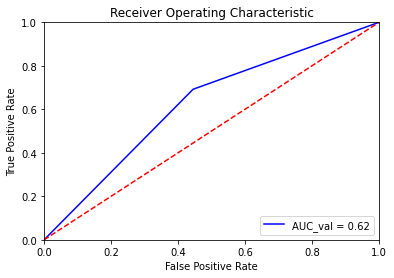

validation avec SVM_disgust_ravdess_MODEL.pkl :

 accuracy_val: 0.9015151515151515 


 confusion_matrix_val 
 [[170   3]
 [ 23  68]]

 precision_val : 0.9577464788732394

 recall_val : 0.7472527472527473

 f1_score : 0.839506172839506

               precision    recall  f1-score   support

           0       0.88      0.98      0.93       173
           1       0.96      0.75      0.84        91

    accuracy                           0.90       264
   macro avg       0.92      0.86      0.88       264
weighted avg       0.91      0.90      0.90       264



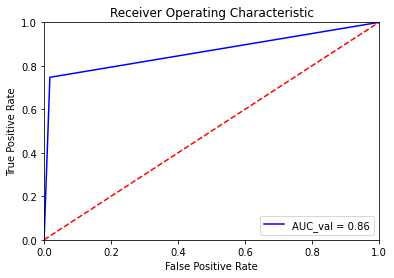

validation avec SGD_disgust_ravdess_MODEL.pkl :

 accuracy_val: 0.7196969696969697 


 confusion_matrix_val 
 [[136  37]
 [ 37  54]]

 precision_val : 0.5934065934065934

 recall_val : 0.5934065934065934

 f1_score : 0.5934065934065934

               precision    recall  f1-score   support

           0       0.79      0.79      0.79       173
           1       0.59      0.59      0.59        91

    accuracy                           0.72       264
   macro avg       0.69      0.69      0.69       264
weighted avg       0.72      0.72      0.72       264



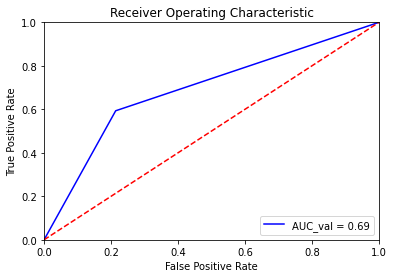

validation avec RF_disgust_ravdess_MODEL.pkl :

 accuracy_val: 0.8371212121212122 


 confusion_matrix_val 
 [[154  19]
 [ 24  67]]

 precision_val : 0.7790697674418605

 recall_val : 0.7362637362637363

 f1_score : 0.7570621468926554

               precision    recall  f1-score   support

           0       0.87      0.89      0.88       173
           1       0.78      0.74      0.76        91

    accuracy                           0.84       264
   macro avg       0.82      0.81      0.82       264
weighted avg       0.84      0.84      0.84       264



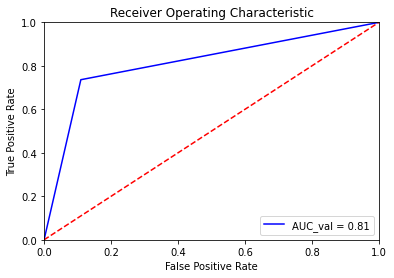

validation avec Xgboost_disgust_ravdess_MODEL.pkl :

 accuracy_val: 0.8484848484848485 


 confusion_matrix_val 
 [[153  20]
 [ 20  71]]

 precision_val : 0.7802197802197802

 recall_val : 0.7802197802197802

 f1_score : 0.7802197802197802

               precision    recall  f1-score   support

           0       0.88      0.88      0.88       173
           1       0.78      0.78      0.78        91

    accuracy                           0.85       264
   macro avg       0.83      0.83      0.83       264
weighted avg       0.85      0.85      0.85       264



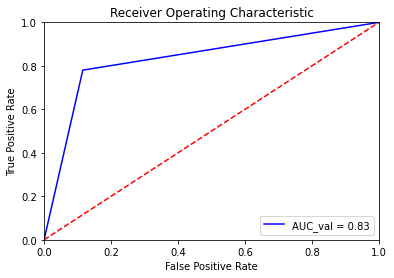

In [ ]:
#testing sauvegarded model on Val dataset
loaded = ['LR_disgust_ravdess_MODEL.pkl', 'KNN_disgust_ravdess_MODEL.pkl', 'CART_disgust_ravdess_MODEL.pkl', 
          'NB_disgust_ravdess_MODEL.pkl','SVM_disgust_ravdess_MODEL.pkl', 'SGD_disgust_ravdess_MODEL.pkl',
          'RF_disgust_ravdess_MODEL.pkl', 'Xgboost_disgust_ravdess_MODEL.pkl']


for filename in loaded:
    loaded_model = joblib.load(filename)
    X_val_array =  np.asarray(X_val)
    result_val = loaded_model.predict(X_val_array)

    print('validation avec' ,filename , ':')
    
    print('\n accuracy_val:',accuracy_score(y_val, result_val),'\n')
    conf_val = confusion_matrix(y_val, result_val)
    print ('\n confusion_matrix_val \n',conf_val)

    print ('\n precision_val :', precision_score(y_val, result_val))
    print('\n recall_val :', recall_score(y_val, result_val))
    print('\n f1_score :', f1_score(y_val, result_val))

    print('\n' ,classification_report(y_val, result_val))

    


    #auc_val
    fpr, tpr, threshold = metrics.roc_curve(y_val, result_val) 
    roc_auc_val = metrics.auc(fpr, tpr)
    
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC_val = %0.2f' % roc_auc_val)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

Validation

validation avec LR_disgust_ravdess_MODEL.pkl :

 accuracy_val: 0.7348484848484849 


 confusion_matrix_val 
 [[151  22]
 [ 48  43]]

 precision_val : 0.6615384615384615

 recall_val : 0.4725274725274725

 f1_score : 0.5512820512820512

               precision    recall  f1-score   support

           0       0.76      0.87      0.81       173
           1       0.66      0.47      0.55        91

    accuracy                           0.73       264
   macro avg       0.71      0.67      0.68       264
weighted avg       0.73      0.73      0.72       264



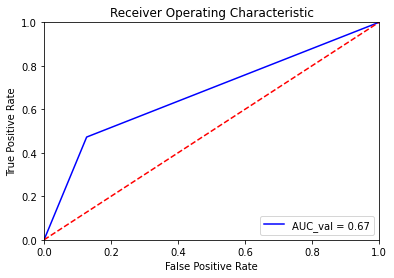

validation avec KNN_disgust_ravdess_MODEL.pkl :

 accuracy_val: 0.8522727272727273 


 confusion_matrix_val 
 [[137  36]
 [  3  88]]

 precision_val : 0.7096774193548387

 recall_val : 0.967032967032967

 f1_score : 0.8186046511627908

               precision    recall  f1-score   support

           0       0.98      0.79      0.88       173
           1       0.71      0.97      0.82        91

    accuracy                           0.85       264
   macro avg       0.84      0.88      0.85       264
weighted avg       0.89      0.85      0.86       264



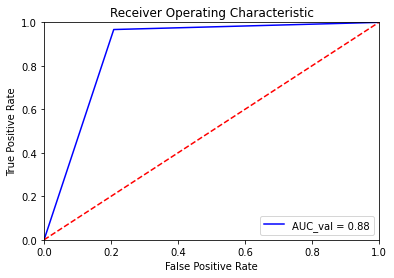

validation avec CART_disgust_ravdess_MODEL.pkl :

 accuracy_val: 0.7537878787878788 


 confusion_matrix_val 
 [[138  35]
 [ 30  61]]

 precision_val : 0.6354166666666666

 recall_val : 0.6703296703296703

 f1_score : 0.6524064171122994

               precision    recall  f1-score   support

           0       0.82      0.80      0.81       173
           1       0.64      0.67      0.65        91

    accuracy                           0.75       264
   macro avg       0.73      0.73      0.73       264
weighted avg       0.76      0.75      0.76       264



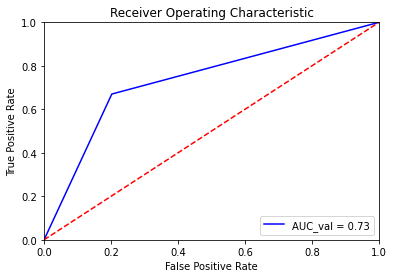

validation avec NB_disgust_ravdess_MODEL.pkl :

 accuracy_val: 0.6022727272727273 


 confusion_matrix_val 
 [[96 77]
 [28 63]]

 precision_val : 0.45

 recall_val : 0.6923076923076923

 f1_score : 0.5454545454545455

               precision    recall  f1-score   support

           0       0.77      0.55      0.65       173
           1       0.45      0.69      0.55        91

    accuracy                           0.60       264
   macro avg       0.61      0.62      0.60       264
weighted avg       0.66      0.60      0.61       264



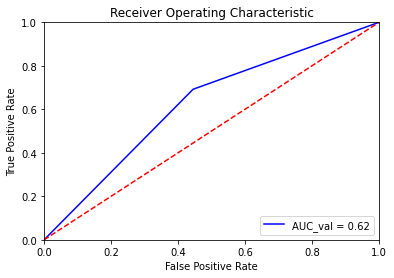

validation avec SVM_disgust_ravdess_MODEL.pkl :

 accuracy_val: 0.9015151515151515 


 confusion_matrix_val 
 [[170   3]
 [ 23  68]]

 precision_val : 0.9577464788732394

 recall_val : 0.7472527472527473

 f1_score : 0.839506172839506

               precision    recall  f1-score   support

           0       0.88      0.98      0.93       173
           1       0.96      0.75      0.84        91

    accuracy                           0.90       264
   macro avg       0.92      0.86      0.88       264
weighted avg       0.91      0.90      0.90       264



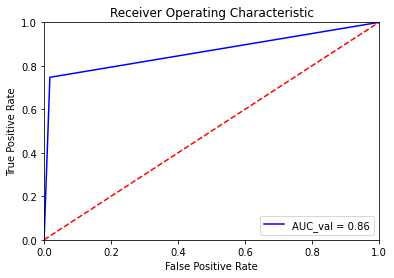

validation avec SGD_disgust_ravdess_MODEL.pkl :

 accuracy_val: 0.7196969696969697 


 confusion_matrix_val 
 [[146  27]
 [ 47  44]]

 precision_val : 0.6197183098591549

 recall_val : 0.4835164835164835

 f1_score : 0.5432098765432098

               precision    recall  f1-score   support

           0       0.76      0.84      0.80       173
           1       0.62      0.48      0.54        91

    accuracy                           0.72       264
   macro avg       0.69      0.66      0.67       264
weighted avg       0.71      0.72      0.71       264



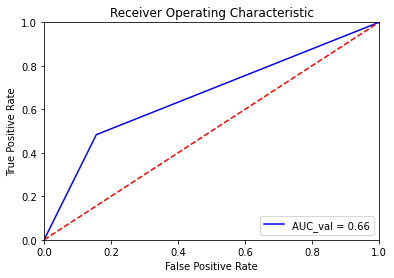

validation avec RF_disgust_ravdess_MODEL.pkl :

 accuracy_val: 0.8295454545454546 


 confusion_matrix_val 
 [[151  22]
 [ 23  68]]

 precision_val : 0.7555555555555555

 recall_val : 0.7472527472527473

 f1_score : 0.7513812154696132

               precision    recall  f1-score   support

           0       0.87      0.87      0.87       173
           1       0.76      0.75      0.75        91

    accuracy                           0.83       264
   macro avg       0.81      0.81      0.81       264
weighted avg       0.83      0.83      0.83       264



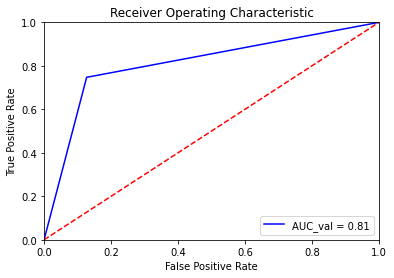

validation avec Xgboost_disgust_ravdess_MODEL.pkl :

 accuracy_val: 0.8484848484848485 


 confusion_matrix_val 
 [[153  20]
 [ 20  71]]

 precision_val : 0.7802197802197802

 recall_val : 0.7802197802197802

 f1_score : 0.7802197802197802

               precision    recall  f1-score   support

           0       0.88      0.88      0.88       173
           1       0.78      0.78      0.78        91

    accuracy                           0.85       264
   macro avg       0.83      0.83      0.83       264
weighted avg       0.85      0.85      0.85       264



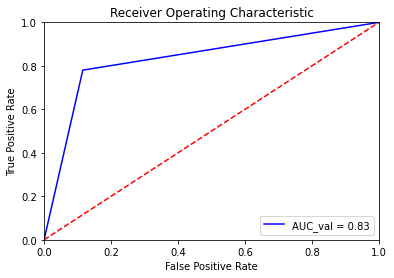

In [ ]:
#testing sauvegarded model on Val dataset
loaded = ['LR_disgust_ravdess_MODEL.pkl', 'KNN_disgust_ravdess_MODEL.pkl', 'CART_disgust_ravdess_MODEL.pkl', 
          'NB_disgust_ravdess_MODEL.pkl','SVM_disgust_ravdess_MODEL.pkl', 'SGD_disgust_ravdess_MODEL.pkl',
          'RF_disgust_ravdess_MODEL.pkl', 'Xgboost_disgust_ravdess_MODEL.pkl']


for filename in loaded:
    loaded_model = joblib.load(filename)
    X_val_array =  np.asarray(X_val)
    result_val = loaded_model.predict(X_val_array)

    print('validation avec' ,filename , ':')
    
    print('\n accuracy_val:',accuracy_score(y_val, result_val),'\n')
    conf_val = confusion_matrix(y_val, result_val)
    print ('\n confusion_matrix_val \n',conf_val)

    print ('\n precision_val :', precision_score(y_val, result_val))
    print('\n recall_val :', recall_score(y_val, result_val))
    print('\n f1_score :', f1_score(y_val, result_val))

    print('\n' ,classification_report(y_val, result_val))

    


    #auc_val
    fpr, tpr, threshold = metrics.roc_curve(y_val, result_val) 
    roc_auc_val = metrics.auc(fpr, tpr)
    
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC_val = %0.2f' % roc_auc_val)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()